In [5]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

[1] "RUnit"         "GenomicRanges" "GenomeInfoDb"  "IRanges"      
 [5] "S4Vectors"     "BiocGenerics"  "parallel"      "stats4"       
 [9] "RPostgreSQL"   "DBI"           "caTools"       "caret"        
[13] "lattice"       "stringr"       "ROCR"          "gplots"       
[17] "pROC"          "tidyr"         "dplyr"         "glmnet"       
[21] "foreach"       "Matrix"        "xgboost"       "ggplot2"      
[25] "RColorBrewer"  "stats"         "graphics"      "grDevices"    
[29] "utils"         "datasets"      "methods"       "base"

In [3]:
load("Rdata_files/motif_class_pairs.Rdata")
load("Rdata_files/Tfmotifmap.Rdata")

In [6]:
load("/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.annotated.9.Rdata")

In [9]:
colnames(all.TF.df.fimo.hint.well.annotated) <- make.names(colnames(all.TF.df.fimo.hint.well.annotated), unique=TRUE)

all.TF.df.fimo.hint.well.annotated %>%
    filter(h_frac > 0 | w_frac > 0 | cs_hit > 0) ->
    df_only_footprint_hits

In [11]:
df_only_footprint_hits %>%
    select(chrom,
           cs_hit,
           motifname,
           motifscore,
           h_frac,
           h_max_score,
           w_frac,
           w_min_score,
           gc_content,
           asinh_tss_dist) ->
    df_cols_selected

head(df_cols_selected)

chrom,cs_hit,motifname,motifscore,h_frac,h_max_score,w_frac,w_min_score,gc_content,asinh_tss_dist
1,1,Mmusculus-jaspar2016-Nfe2l2-MA0150.2,13.34830,0.48,2096,0.13333333,-33.02390,0.6119403,10.29384
1,1,Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1,11.70790,0.46,2096,0.13333333,-33.02390,0.6169154,10.29377
1,1,Hsapiens-jaspar2016-JUND(var.2)-MA0492.1,9.73034,0.22,207,0.06666667,-5.38997,0.3283582,11.47418
1,1,Hsapiens-jaspar2016-ATF7-MA0834.1,8.03371,0.14,465,0.30000000,-33.99660,0.5174129,10.90485
1,1,Hsapiens-jaspar2016-JUND(var.2)-MA0492.1,13.71910,0.08,257,0.16666667,-33.61900,0.4875622,10.90018
1,1,Hsapiens-jaspar2016-JUND(var.2)-MA0492.1,13.71910,0.22,277,0.23333333,-32.24370,0.5024876,10.90143


In [12]:
df_cols_selected %>%
    filter(chrom %in% c("2","4")) %>%
    select(-chrom) ->
    val_df

df_cols_selected %>%
    filter(chrom %in% c("1","3","5")) %>%
    select(-chrom) ->
    test_df

df_cols_selected %>%
    filter(!(chrom %in% c("1","2","3","4","5"))) %>%
    select(-chrom) ->
    train_df

remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits)

In [13]:
head(train_df)

cs_hit,motifname,motifscore,h_frac,h_max_score,w_frac,w_min_score,gc_content,asinh_tss_dist
1,Hsapiens-jaspar2016-JUND-MA0491.1,10.85390,0.08,48,0.03333333,-7.57656,0.3980100,12.51923
1,Hsapiens-jaspar2016-JUND-MA0491.1,9.52809,0.14,61,0.13333333,-16.41650,0.3830846,12.51897
1,Mmusculus-jaspar2016-Nfe2l2-MA0150.2,17.87640,0.30,908,0.20000000,-12.93590,0.4129353,12.18085
1,Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1,9.05618,0.30,908,0.20000000,-12.93590,0.4129353,12.18084
1,Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1,9.52809,0.38,1329,0.23333333,-8.29572,0.4577114,12.00326
1,Hsapiens-jaspar2016-JUND-MA0491.1,9.47191,0.14,96,0.03333333,-8.12638,0.5124378,12.00211


In [14]:
all_stats_df <- data.frame()

for (TF in names(TFs.to.motifs)) {
    
    # get motifs matching this TF
    this_tfs_motifs <- TFs.to.motifs[[TF]]
    
    # filter down to only relevant motifs
    train_df %>%
        filter(motifname %in% this_tfs_motifs) ->
        this_tf_train_df
    test_df %>%
        filter(motifname %in% this_tfs_motifs) ->
        this_tf_test_df
    
    # make training and testing data sets
    X_train_this_tf <- as.matrix(select(this_tf_train_df,-one_of("cs_hit", "motifname")))
    y_train_this_tf <- this_tf_train_df$cs_hit
    X_test_this_tf <- as.matrix(select(this_tf_test_df,-one_of("cs_hit", "motifname")))
    y_test_this_tf <- this_tf_test_df$cs_hit
    
    # set parameters for gbdt
    param <- list("objective" = "binary:logistic",
          "max.depth" = 5,
          "eta" = 0.01,
          "eval.metric" = "auc"
          )
    
    # train gbdt
    gbdt_tf <- xgboost(
        params = param,
        data = X_train_this_tf,
        label = y_train_this_tf,
        nround = 100,
        verbose = FALSE,
        missing = NA
    )
    gbdt_tf$Model.Name <- TF
    
    
    # gather statistics for model on this TF
    this_tf_pred_df <- make.pred.df.from.model(gbdt_tf, X_test_this_tf, y_test_this_tf)
    colnames(this_tf_pred_df)[1] <- "ChIPseq.bound"
    this_tf_stat_df <- make.stats.df.from.preds(this_tf_pred_df)
    this_tf_stat_df$Train.Samples <- length(y_train_this_tf)
    this_tf_stat_df$Test.Samples <- length(y_test_this_tf)
    
    # save stats
    all_stats_df <- rbind(all_stats_df, this_tf_stat_df)

}

In [15]:
str(all_stats_df)

'data.frame':	6262 obs. of  10 variables:
 $ threshold    : num  0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 ...
 $ sensitivity  : num  1 1 1 1 1 1 1 1 1 1 ...
 $ specificity  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ppv          : num  0.493 0.493 0.493 0.493 0.493 ...
 $ npv          : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ accuracy     : num  0.493 0.493 0.493 0.493 0.493 ...
 $ MattCC       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Model.Name   : chr  "ATF2" "ATF2" "ATF2" "ATF2" ...
 $ Train.Samples: int  63903 63903 63903 63903 63903 63903 63903 63903 63903 63903 ...
 $ Test.Samples : int  18970 18970 18970 18970 18970 18970 18970 18970 18970 18970 ...


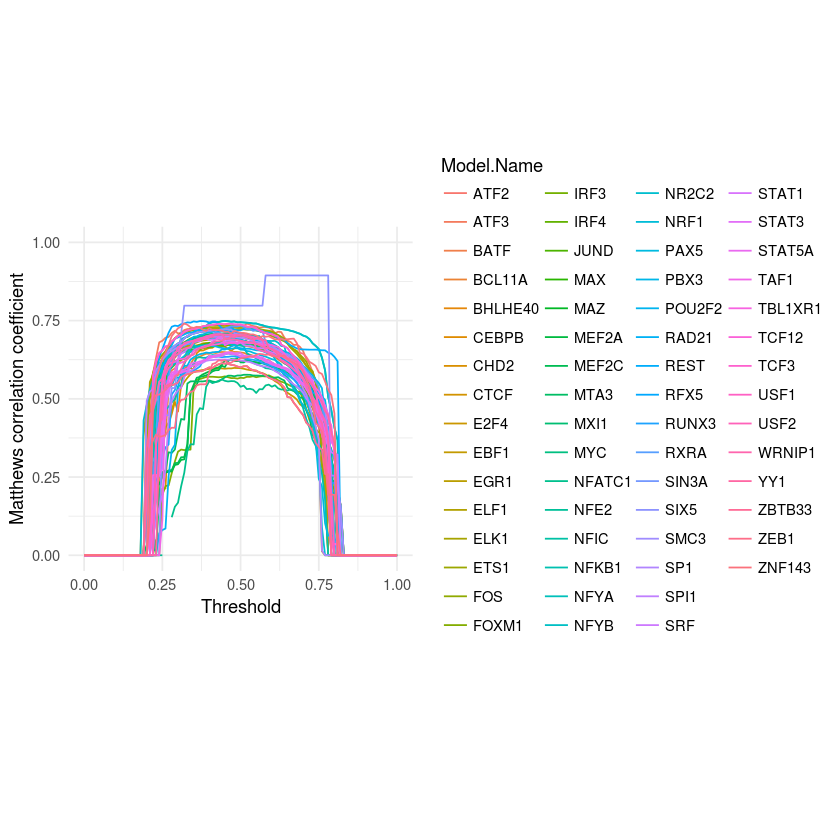

In [16]:
plot.mattcc.curve(all_stats_df) + theme_minimal()

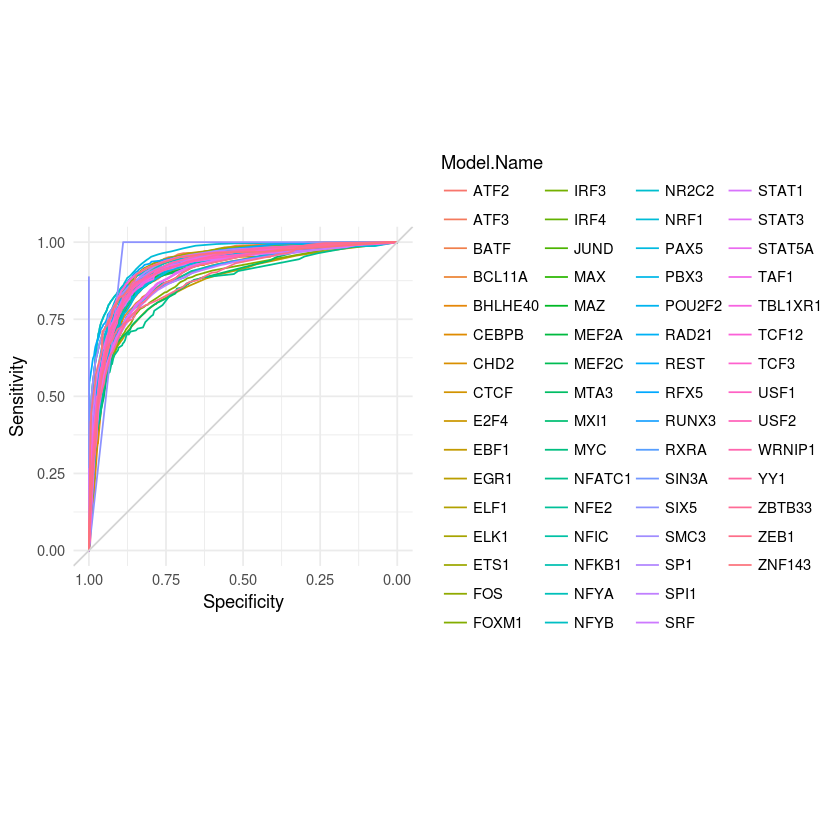

In [17]:
plot.roc.curve(all_stats_df) + theme_minimal()

Warning message:
“Removed 1271 rows containing missing values (geom_path).”

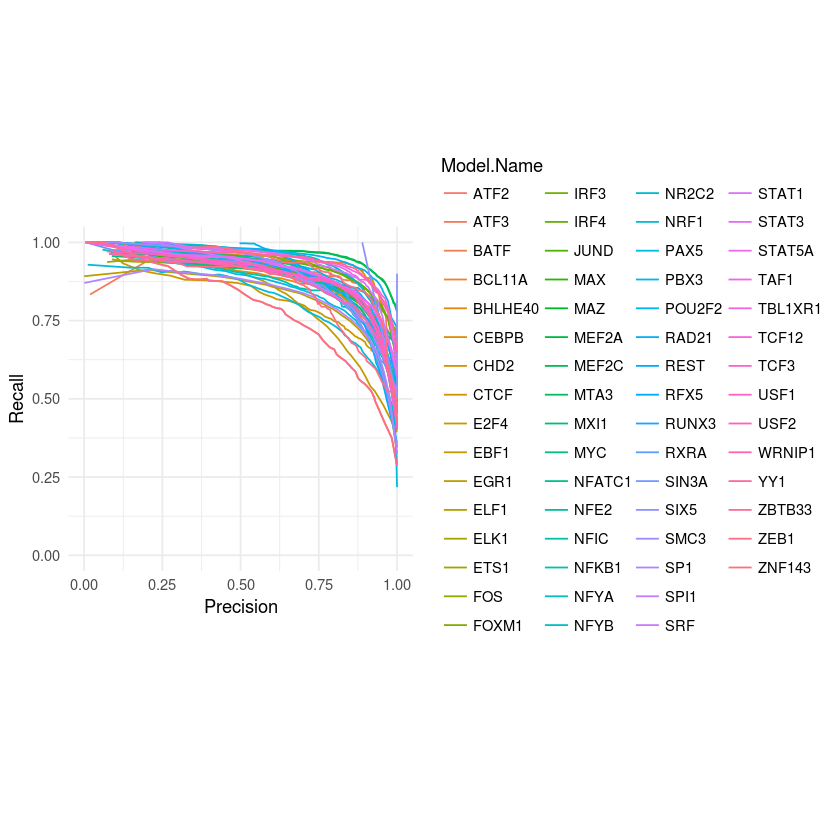

In [18]:
plot.precrecall.curve(all_stats_df) + theme_minimal()

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`


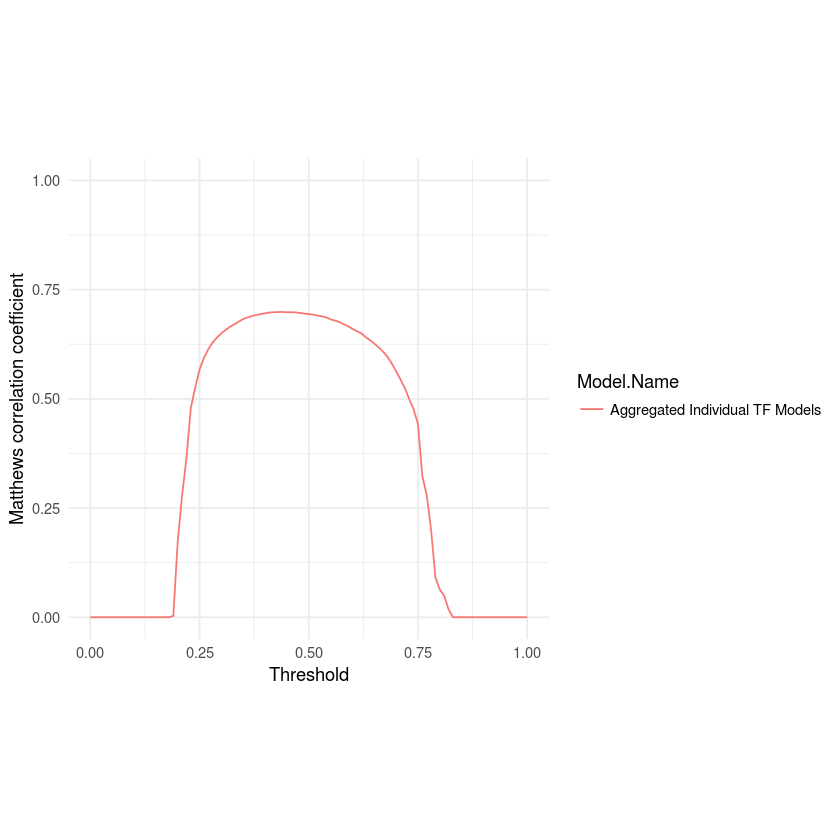

In [19]:
all_stats_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual TF Models") %>%
    plot.mattcc.curve

In [20]:
all_stats_motif_df <- data.frame()

motifs <- unique(train_df$motifname) %>% intersect(unique(test_df$motifname))
for (motif in motifs) {
    
    # filter down to only relevant motifs
    train_df %>%
        filter(motifname == motif) ->
        this_motif_train_df
    test_df %>%
        filter(motifname == motif) ->
        this_motif_test_df
    
    # make training and testing data sets
    X_train_this_motif <- as.matrix(select(this_motif_train_df,-one_of("cs_hit", "motifname")))
    y_train_this_motif <- this_motif_train_df$cs_hit
    X_test_this_motif <- as.matrix(select(this_motif_test_df,-one_of("cs_hit", "motifname")))
    y_test_this_motif <- this_motif_test_df$cs_hit
    
    # set parameters for gbdt
    param <- list("objective" = "binary:logistic",
          "max.depth" = 5,
          "eta" = 0.01,
          "eval.metric" = "auc"
          )
    
    # train gbdt
    gbdt_motif <- xgboost(
        params = param,
        data = X_train_this_motif,
        label = y_train_this_motif,
        nround = 100,
        verbose = FALSE,
        missing = NA
    )
    gbdt_motif$Model.Name <- motif
    
    
    # gather statistics for model on this motif
    this_motif_pred_df <- make.pred.df.from.model(gbdt_motif, X_test_this_motif, y_test_this_motif)
    colnames(this_motif_pred_df)[1] <- "ChIPseq.bound"
    this_motif_stat_df <- make.stats.df.from.preds(this_motif_pred_df)
    this_motif_stat_df$Train.Samples <- length(y_train_this_motif)
    this_motif_stat_df$Test.Samples <- length(y_test_this_motif)
    
    # save stats
    all_stats_motif_df <- rbind(all_stats_motif_df, this_motif_stat_df)

}

In [21]:
load(file="per_TF_output/all_together_tree_stats.Rdata")
medium_stat_df$Model.Name <- "All together Trees with Classes"

In [22]:
all_stats_motif_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual Motif Models") ->
    aggreagate_stats_motif_df

all_stats_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual TF Models") ->
    aggreagate_stats_TF_df

compare_methods_df <- rbind(aggreagate_stats_motif_df, aggreagate_stats_TF_df, medium_stat_df)

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`
`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`


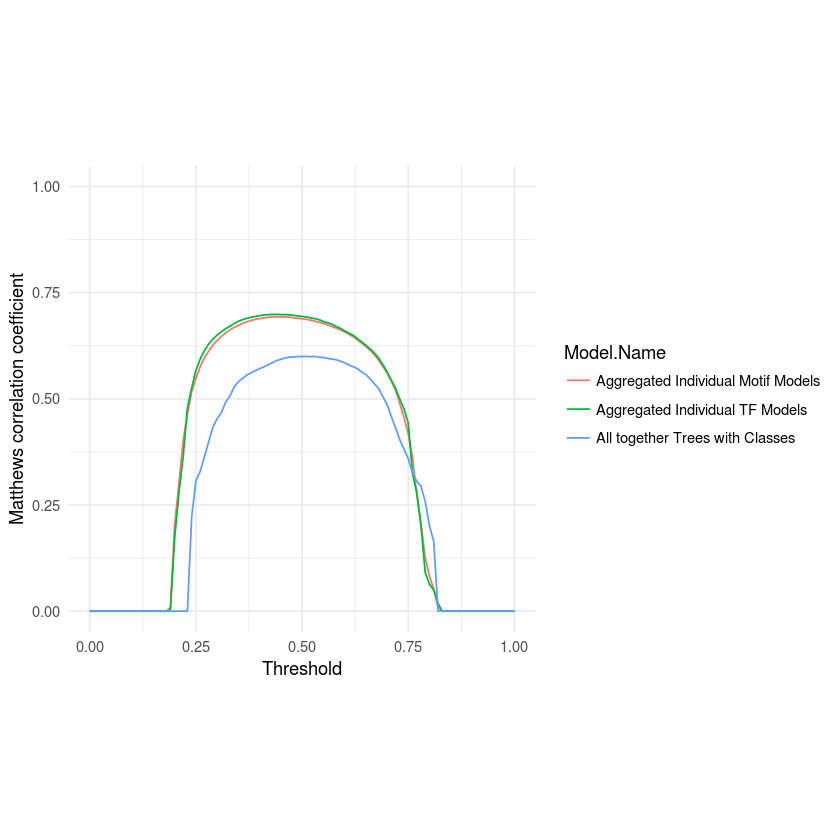

In [23]:
plot.mattcc.curve(compare_methods_df)

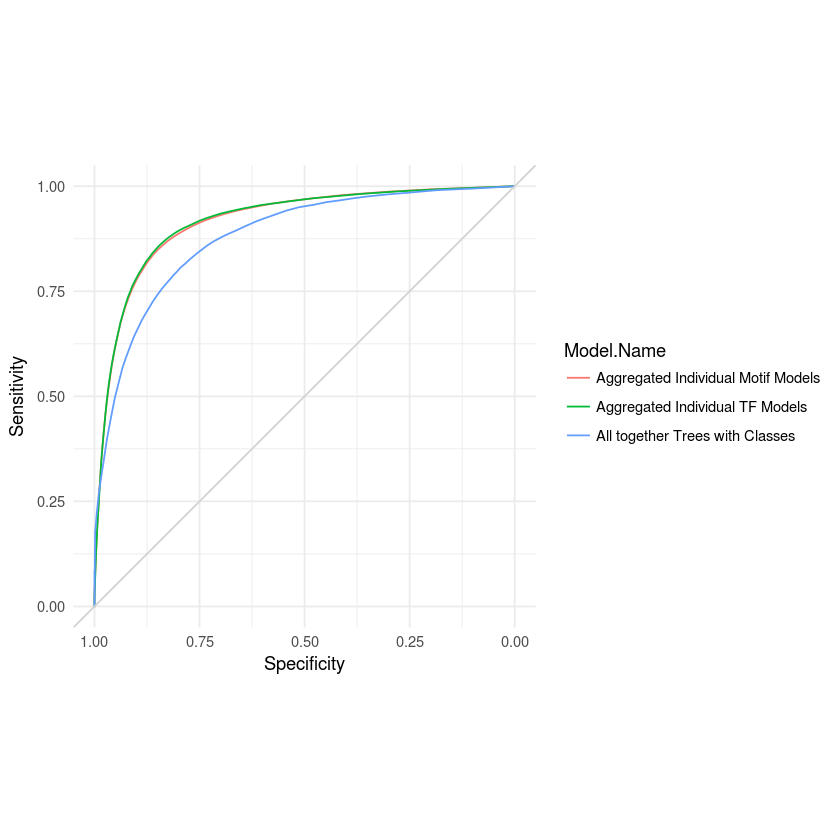

In [24]:
plot.roc.curve(compare_methods_df)

Warning message:
“Removed 94 rows containing missing values (geom_path).”

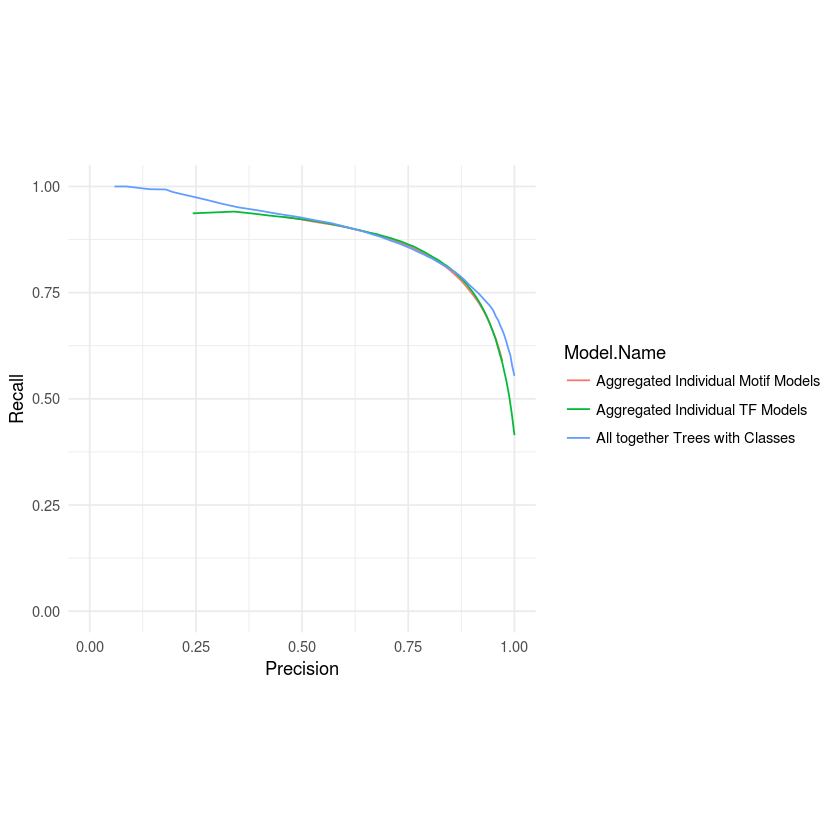

In [25]:
plot.precrecall.curve(compare_methods_df)